In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator
from sympy import Matrix

N_qubits = 3
t = 1.0
A = np.random.uniform(0,1, size=(2**(N_qubits)-1,2**(N_qubits)-1))
B = np.random.uniform(0,1, size=(2**(N_qubits)-1,2**(N_qubits)-1))

M = A + 1j*B
M = M + np.conjugate(M).T
H = np.zeros((2**N_qubits,2**N_qubits), dtype=complex)
H[1:,1:] = M
H[0,0] = 3.0

U = expm(1j*H*t)


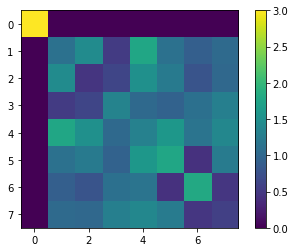

In [2]:
plt.imshow(np.abs(H))
plt.colorbar()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


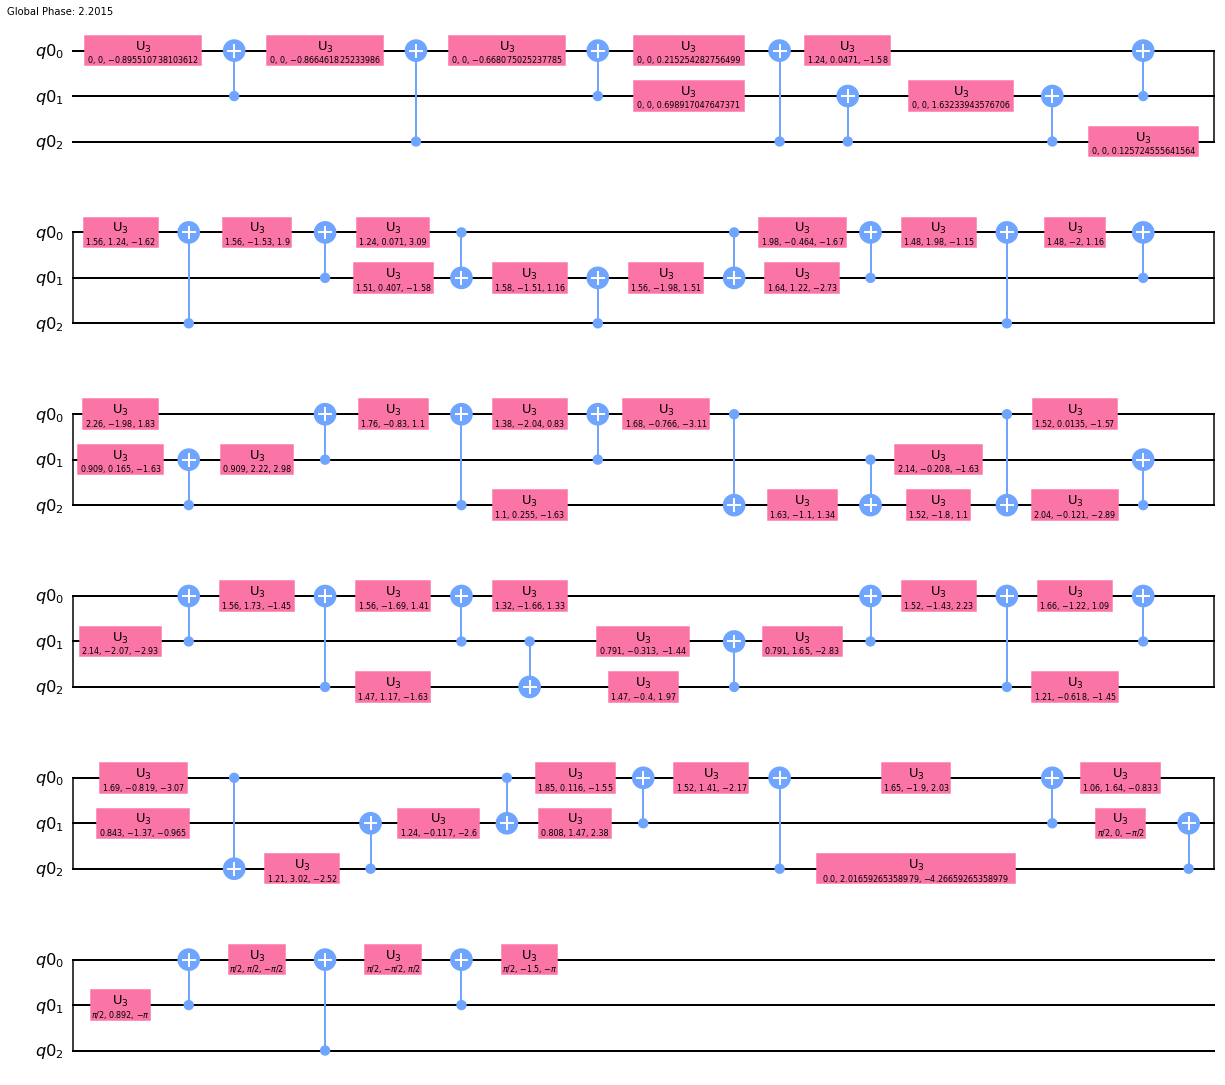

In [3]:
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

qr = QuantumRegister(N_qubits)
circ = QuantumCircuit(qr)
circ.unitary(U, qr)
circuit = transpile(circ, basis_gates=["cx", "u3"])
circuit.draw(output="mpl")

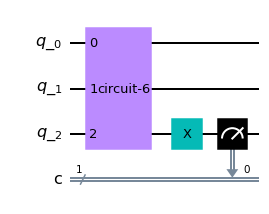

In [4]:
cal_circ, state_labels = utilities.get_tensored_calibration_circuits(circuit, method="NIC", eigenvector=N_qubits*"0")
cal_circ[-1].draw(output="mpl")

In [5]:
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
from qiskit.quantum_info import Operator

qr_prep = QuantumRegister(N_qubits)
circuit_prepared = QuantumCircuit(qr_prep)

circuit_prepared.x([qr_prep[1]])
circuit_prepared.append(circuit, qr_prep)

tomo_circuits = state_tomography_circuits(circuit_prepared, qr_prep)

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000
reps = 1 # ATTENZIONE NON PUOI METTEREE PIU DI 1

job_NIC=execute(cal_circ, backend = BACKEND, shots=shots)
job_CIC=execute(cal_circ, backend = BACKEND, shots=shots)

job_tomography=execute(tomo_circuits, backend = BACKEND, shots=shots)

In [7]:
#################################### Mititgation of the raw results

# building the measured caliration martices from the results

def occurences_to_matrix_2x2(counts_dict_0, counts_dict_1):
    matrix = np.zeros([2,2])
    for key in counts_dict_0:
        matrix[int(key, 2), 0] = counts_dict_0[key]
    for key in counts_dict_1:
        matrix[int(key, 2), 1] = counts_dict_1[key]
    return matrix/sum(counts_dict_0.values())

U_tilde_SSD_CIC = 1
U_tilde_SSD_NIC = 1
i=4
for i in np.arange(2*N_qubits, step=2):
    print(i)
    counts_SSD_NIC = job_NIC.result().get_counts()
    matrix2x2_NIC = occurences_to_matrix_2x2(counts_SSD_NIC[i], counts_SSD_NIC[i+1])
    U_tilde_SSD_NIC = np.kron(U_tilde_SSD_NIC, matrix2x2_NIC)

    counts_SSD_CIC = job_CIC.result().get_counts()
    matrix2x2_CIC = occurences_to_matrix_2x2(counts_SSD_CIC[i], counts_SSD_CIC[i+1])
    U_tilde_SSD_CIC = np.kron(U_tilde_SSD_CIC, matrix2x2_CIC)
    print(matrix2x2_CIC)

# make a fake meas_fitter

qr_cal = QuantumRegister(N_qubits)
calib_circuits_qiskit, state_labels = complete_meas_cal(qubit_list=list(np.arange(N_qubits)), qr=qr_cal, circlabel='mcal')
job_qiskit=execute(calib_circuits_qiskit, backend = backend_sim_noisy_jakarta, shots=shots)
meas_fitters_fake = CompleteMeasFitter(job_qiskit.result(), state_labels=state_labels)

0
[[0.7699 0.2696]
 [0.2301 0.7304]]
2
[[0.769   0.23295]
 [0.231   0.76705]]
4
[[0.7978  0.21285]
 [0.2022  0.78715]]


In [8]:
# U_ideal is the unitary matrix of the circuit qc_U, we will use it for the CIC method.
U_ideal_SSD = Operator(circuit)
# defining the tomography basis circuits.
qr_basi = QuantumRegister(N_qubits)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

# compute the probability matrix of U_ideal and the inverse of it.
U_ideal_SSD_abs = np.abs(U_ideal_SSD)**2
U_ideal_SSD_abs_inv = np.linalg.inv(U_ideal_SSD_abs)
# built the calibration matrix in the computational basis for both CIC and NIC methods.
C_SSD_CIC = np.dot(U_tilde_SSD_CIC, U_ideal_SSD_abs_inv)
C_SSD_NIC = U_tilde_SSD_NIC
# building the fast tomography circuits calibration.
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
raw_result_SSD = job_tomography.result()
NIC_result_SSD = copy.deepcopy(raw_result_SSD)
CIC_result_SSD = copy.deepcopy(raw_result_SSD)
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2
    # change the basis of the calibration matrices for NIC and CIC.
    #C_basis_CIC = np.linalg.multi_dot([base_matrix, C_SSD_CIC,  base_matrix_inverse])
    #C_basis_NIC = np.linalg.multi_dot([base_matrix, C_SSD_NIC,  base_matrix_inverse])
    C_basis_CIC = np.abs(np.linalg.multi_dot([base_matrix_amplitudes, C_SSD_CIC,  base_matrix_amplitudes_inverse]))**2
    C_basis_NIC = np.abs(np.linalg.multi_dot([base_matrix_amplitudes, C_SSD_NIC,  base_matrix_amplitudes_inverse]))**2
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitters_fake)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    # changing the meas_fitter_SSD_CIC calibration matrix with the new calibration matrix. 
    meas_fitter_CIC_aus = copy.deepcopy(meas_fitters_fake)
    meas_fitter_CIC_aus._tens_fitt.cal_matrices[0]=C_basis_CIC
    # computing the new counts for both the mitigation techniques
    old_counts=raw_result_SSD.get_counts(basis)
    new_counts_NIC = meas_fitter_NIC_aus.filter.apply(old_counts, method="least_squares")
    new_counts_CIC = meas_fitter_CIC_aus.filter.apply(old_counts, method="least_squares")
    NIC_result_SSD.results[i].data.counts = new_counts_NIC
    CIC_result_SSD.results[i].data.counts = new_counts_CIC

In [9]:
# target_state = (One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |110>)
target_state = U[:,2]
# compute the fidelity
fid_raw = utilities.fidelity_count(raw_result_SSD, tomo_circuits, target_state)
fid_NIC = utilities.fidelity_count(NIC_result_SSD, tomo_circuits, target_state)
fid_CIC = utilities.fidelity_count(CIC_result_SSD, tomo_circuits, target_state)
# print the result
print(f"fidelity of raw results: {fid_raw} \nfidelity with NIC method: {fid_NIC}\nfidelity with CIC method: {fid_CIC}   this is the fidelity score for the challenge.")

fidelity of raw results: 0.43946614459776967 
fidelity with NIC method: 0.6823364966640343
fidelity with CIC method: 0.007008895665586372   this is the fidelity score for the challenge.


In [10]:
#################################################################
#################################################### Mititgation 
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
from qiskit.quantum_info import Operator
# building the matrices
meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)

# copy the measured probability matrices.
U_tilde_NIC = meas_fitter_NIC.cal_matrix
# defining the tomography basis circuits
qr_basi = QuantumRegister(N_qubits)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)
# builds the calibration matrix in the computational basis for NIC methods
C_NIC = U_tilde_NIC
plt.imshow(C_NIC)
plt.colorbar()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "mcalcal_000", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(


KeyError: '1'

[[0.55455 0.10655 0.1013  0.0708  0.0814  0.05645 0.0676  0.0442 ]
 [0.0815  0.52895 0.0601  0.10715 0.05075 0.08245 0.0358  0.06355]
 [0.089   0.0732  0.56515 0.0823  0.06255 0.03825 0.06535 0.0585 ]
 [0.05875 0.0829  0.0866  0.5345  0.0326  0.06175 0.04635 0.08435]
 [0.06325 0.05205 0.0573  0.0369  0.5404  0.09875 0.10025 0.0647 ]
 [0.05135 0.0625  0.03095 0.06515 0.086   0.5255  0.06995 0.08265]
 [0.0666  0.03585 0.05335 0.04765 0.0807  0.0634  0.5455  0.0872 ]
 [0.035   0.058   0.04525 0.05555 0.0656  0.07345 0.0692  0.51485]]


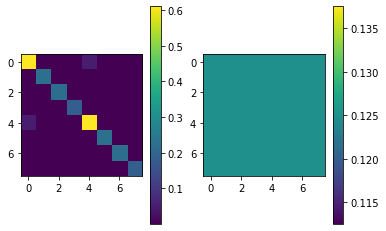

In [ ]:

# fast tomography circuits calibration:
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
meas_fitters_NIC = []
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = base_matrix_amplitudes.transpose().conjugate()
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_basis_NIC = np.abs(np.linalg.multi_dot([base_matrix_amplitudes, C_NIC,  base_matrix_amplitudes_inverse]))**2
    #C_basis_NIC = np.linalg.multi_dot([base_matrix, C_NIC,  base_matrix_inverse])
    #C_basis_NIC = np.abs(np.dot(base_matrix_amplitudes, C_NIC))**2
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    meas_fitters_NIC.append(meas_fitter_NIC_aus)

    if i==1:
        plt.subplot(121)
        plt.imshow(meas_fitters_NIC[i].cal_matrix)
        plt.colorbar()

        plt.subplot(122)
        plt.imshow(base_matrix)
        plt.colorbar()

        print(C_NIC)

plt.show()


In [ ]:

################################### mitigates the raw results
raw_result = [] #jobs_tomo_SSD[rep].result()
NIC_result = [] #copy.deepcopy(raw_result_SSD)
for rep in range(reps):
    #raw_result_SSD.append(jobs_tomography[rep].result())
    raw_result.append(job_tomography.result())
    NIC_result.append(copy.deepcopy(raw_result[rep]))
    for i in range(3**N_qubits):
        # computing the new counts for both the mitigation techniques
        old_counts=raw_result[rep].get_counts(i)
        new_counts_NIC = meas_fitters_NIC[i].filter.apply(old_counts, method="least_squares")
        NIC_result[rep].results[i].data.counts = new_counts_NIC

In [ ]:
from qiskit.opflow import One, Zero

# defining the target_state = |110> ; qubits: |5,3,1>
# target_state = (One^One^Zero).to_matrix()
target_state = U[:,2]
# compute the fidelity for each repetition
fids_SSD = {"raw": np.zeros(reps), "NIC": np.zeros(reps), "CIC": np.zeros(reps)}
for rep in range(reps):
    fids_SSD["raw"][rep] = utilities.fidelity_count(raw_result[rep], tomo_circuits, target_state)
    fids_SSD["NIC"][rep] = utilities.fidelity_count(NIC_result[rep], tomo_circuits, target_state)
# computes the mean and the standard deviation
fid_means = {"raw": np.mean(fids_SSD["raw"]), "NIC": np.mean(fids_SSD["NIC"])}
fid_std = {"raw": np.std(fids_SSD["raw"]), "NIC": np.std(fids_SSD["NIC"])}

# fidelity
text2 = "fidelity of raw results: %.5f +- %.5f \n"%(fid_means["raw"],fid_std["raw"])
text2 = text2 + "fidelity with NIC method: %.5f +- %.5f \n" %(fid_means["NIC"],fid_std["NIC"])

print(text2)

fidelity of raw results: 0.45334 +- 0.00000 
fidelity with NIC method: 0.91096 +- 0.00000 

